# Обнаружение каверов музыкальных треков

## Задача

Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье наших пользователей. Если мы умеем с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков. Например:

- по желанию пользователя можем полностью исключить каверы из рекомендаций;
- показать все каверы на любимый трек пользователя;
- контролировать долю каверов в ленте пользователя.

## Цель
В этом хакатоне нам предлагается разработать решение, которое:

- может классифицировать треки по признаку кавер-некавер;
- связывать (группировать) каверы и исходный трек;
- находит исходный трек в цепочке каверов.

Нам требуется разработать ML-модель для сопоставления текстов музыкальных произведений и для поиска каверов (вариации обработки оригинала с элементами новой аранжировки) по их текстам. 

Для решения этой задачи мы можем использовать любые открытые источники данных и собирать необходимую вам информацию, соблюдая правила использования сервисов, которые эту информацию предоставляют.

Данные предоставлены заказчиком в трех файлах: covers.json, meta.json, lyrics.json.

### Разметка каверов

Файл covers.json содержит разметку каверов, сделанную редакторами сервиса:

- track_id - уникальный идентификатор трека;
- track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
- original_track_id - уникальный идентификатор исходного трека.

Обратите внимание, что не для всех каверов известны идентификаторы исходных треков!!!

### Метаинформация
Файл meta.json 
- track_id - уникальный идентификатор трека;
- dttm - первая дата появления информации о треке;
- title - название трека;
- language - язык исполнения;
- isrc - международный уникальный идентификатор трека;
- genres - жанры;
- duration - длительность трека;

### Текст песен
Файл lyrics.json
- track_id - уникальный идентификатор трека;
- lyricId - уникальный идентификатор текста;
- text - текст трека.

**Исследование пройдет в 7 этапов:**

* загрузка и первичное ознакомление с данными,
* предварительная обработка,
* полноценный разведочный анализ,
* разработка новых синтетических признаков,
* проверка на мультиколлинеарность,
* отбор финального набора обучающих признаков,
* выбор и обучение моделей,
* итоговая оценка качества предсказания лучшей модели,
* анализ важности ее признаков.
* общий вывод

## Загрузка и первичное ознакомление с данными

Импортируем необходимые для анализа данных библиотеки.

Считаем данные из json-файла в датафрейм и сохраним в переменные.

In [68]:
import json
import os

import warnings
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    roc_curve, 
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)
RANDOM_STATE = 54321
from tqdm.notebook import tqdm
tqdm.pandas()

warnings.filterwarnings("ignore")

### Первичный обзор данных

In [2]:
# разметка каверов
path_covers = 'C:\\Users\\fudou\\Untitled Folder 1\\covers.json'

df_covers = pd.read_json(path_covers, lines=True)
df_covers.sample()

,original_track_id,track_id,track_remake_type
40494,None,bc8da4a8cdd61089853f49e1b9a61185,COVER


In [3]:
# метаинформация
path_meta = 'C:\\Users\\fudou\\Untitled Folder 1\\/meta.json'

df_meta = pd.read_json(path_meta, lines=True, convert_dates=['dttm'])
df_meta.sample()

,track_id,dttm,title,language,isrc,genres,duration
38375,9d5a1a1da8b38b66f9d2f85944a24583,2021-10-28 20:15:02,Sueña,None,QZNJY2113040,"[FOLK, LATINFOLK]",297710.0


In [4]:
# текст трека
path_lyrics = 'C:\\Users\\fudou\\Untitled Folder 1\\/lyrics.json'

df_lyrics = pd.read_json(path_lyrics, lines=True)
df_lyrics.sample()

,lyricId,text,track_id
856,1be58ea05c9cb500832593e7aad64549,"Hey Jude, don't make it bad\nTake a sad song a...",3e3a29eadd78fe4c243ca68bead49f36


In [5]:
# напишем функцию для вывода основной информации о датасетe
def main_info(data):
    print(f'Выведем первые 5 строк датафрейма')
    display(data.head())
    print()

    print(f'Основная информация о датафрейме')
    print()
    display(data.info())
    print()

    print(f'Числовое описание данных')
    display(data.describe().style.background_gradient())
    print()

    print(f'Количество строк-дубликатов')
    display(data.duplicated().sum())
    print()

    print(f'Количество пропусков в процентном соотношении')
    display(pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient())
    print()


**Разметка каверов**

In [6]:
# посмотрим датасет c каверами
main_info(df_covers)

Выведем первые 5 строк датафрейма


,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER



Основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


None


Числовое описание данных


,original_track_id,track_id,track_remake_type
count,4821,71597,71597
unique,4468,71597,2
top,f3e5e9db509f9b6f6d93b9c38e4e1324,6747cf886c2cc6025e226d7130d13ea6,COVER
freq,38,1,67304



Количество строк-дубликатов


0


Количество пропусков в процентном соотношении


,0
original_track_id,93.300000
track_id,0.000000
track_remake_type,0.000000


**Обзор метаинформации**

In [7]:
df_meta.head()

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
2,955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
3,fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0


In [8]:
# посмотрим датасет c метаинформацией
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   track_id  71768 non-null  object        
 1   dttm      71768 non-null  datetime64[ns]
 2   title     71768 non-null  object        
 3   language  21969 non-null  object        
 4   isrc      71455 non-null  object        
 5   genres    71768 non-null  object        
 6   duration  71768 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 3.8+ MB


In [9]:
print(f'Количество пропусков в процентном соотношении')
display(pd.DataFrame(round(df_meta.isna().mean()*100,1)).style.background_gradient())


Количество пропусков в процентном соотношении


,0
track_id,0.000000
dttm,0.000000
title,0.000000
language,69.400000
isrc,0.400000
genres,0.000000
duration,0.000000


**Тексты песен**

In [10]:
# посмотрим датасет c текстами
main_info(df_lyrics)

Выведем первые 5 строк датафрейма


,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659



Основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


None


Числовое описание данных


,lyricId,text,track_id
count,11414,11414,11414
unique,10915,10644,10277
top,28fbafaf626c497d0d4d933b4f0d3f5b,"Twenty-five years and my life is still I'm trying to get up that great big hill of hope For a destination And so I wake in the morning And I step outside And I take a deep breath and I get real high And I scream at the top of my lungs What's going on? And I say, hey hey hey hey, hey hey hey hey I said hey, what's going on? And I say, hey hey, hey hey What's going on? What's going on? And I say, hey hey, hey hey, hey hey, hey hey, hey hey, hey hey What's going on?",b891000882f4a612190142861b5c038b
freq,9,15,24



Количество строк-дубликатов


0


Количество пропусков в процентном соотношении


,0
lyricId,0.000000
text,0.000000
track_id,0.000000


**Вывод после первичного обзора данных**

Датасет с разметкой каверов содержит 71597 объектов и 3 столбца, при этом обнаружено **93 %** пропусков в столбце с original_track_id - уникальный идентификатор исходного трека. При этом 4468 значения являются уникальными из 4821 имеющихся данных об уникальных id исходных треков.   

Датасет с метаинфромацией содержит 71768 объектов и 7 столбцов, пропуски присутствуют в 2х столбцах:language и  isr (международный id трека).             5Датасет с текстами песен содержит около 99% уникальных значений текстов и 95% уникальных значений lyricId.         Н
названия колонои соответствуют первоначальному описанию дан. Сразу видим, что есть одинаковые на первый взгляд тексты песен, при этом track_id у них разный, а lyricId одинаковый.	             т)Типы данных соответствуют содержанию.            cПолных строк дубликатов в разметке каверов и тексте песен нет. Но при ближайшем рассмотрении по столбцам, дубликаты видны.ем наборе данных.

### Проведем более детальную предобработку наших данных
Рассмотрим подробно имеющиеся столбцы

In [11]:
# все дубликаты без пропусков с длительностью больше 0
df_meta[df_meta['isrc'].duplicated(keep=False) & df_meta['isrc'].notna() & df_meta['duration'] > 0].sort_values(by='isrc')

,track_id,dttm,title,language,isrc,genres,duration
27012,be0233f57dbb59079929ac646b0b9d5c,2021-07-06 16:38:30,Zivot da stane ne sme,None,ATAJ12100470,[FOLK],151190.0
26955,8aff9d28865aaf1fa44e46b82cba0f63,2021-07-06 15:38:37,Burma,None,ATAJ12100470,[FOLK],179300.0
51052,196a0973d73122891a426f8334105ce7,2019-03-29 21:00:00,Inní mér syngur vitleysingur,EN,ATN261668711,"[FOLKMETAL, METAL]",237010.0
66395,425761c88ebc69e89c748eb537671953,2018-04-28 19:08:26,Inni Mer Syngur Vitleysingur,None,ATN261668711,"[FOLKMETAL, METAL]",237010.0
51053,aa4a1d4d44890cbc7aae285842bd3ce2,2019-03-29 21:00:00,Nattfödd,EN,ATN261668712,"[FOLKMETAL, METAL]",255320.0
...,...,...,...,...,...,...,...
42673,9ca51834e2b6a7266ebcb10cf9a00409,2014-09-23 12:08:24,How Far We've Come,None,USTCF1018560,"[ROCK, ALLROCK]",200820.0
42671,2e04e2ca902c24028b3a7bcded51deeb,2014-09-23 12:08:24,Angel,None,USTCF1018563,"[ROCK, ALLROCK]",261490.0
67314,7eb1ce7b0e7ce4c053c1c9af0ebd9634,2018-11-08 18:31:51,Angel (2009),EN,USTCF1018563,"[ROCK, ALLROCK]",261450.0
67315,90117fc7a8a5ef80c4d3e1e6e39b4f06,2018-11-08 18:31:51,Breathe (2009),EN,USTCF1018565,"[ROCK, ALLROCK]",221970.0


In [12]:
# все дубликаты без пропусков в lyricId	
df_lyrics[df_lyrics['lyricId'].duplicated(keep=False) & df_lyrics['track_id'].notna() & df_lyrics['text'].notna()].sort_values(by='track_id')

,lyricId,text,track_id
10676,745f700051961898c65ffdafd9793584,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef
10681,039236cf5355b4a81a7d5e689dbbf00a,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef
3951,28a44505928aa595b7aa8077739338d6,[JUDAS PRIEST (Tipton/Halford)]\n\nBehold 'tis...,0027101f608c9be2f149f5a44a18c54d
4164,331799cafa438af8e3addb797662a695,Туземцы крайне опасны\nТуземцы пьют залихватск...,018397ef8f12c6130512d443d130d1c3
8772,699ec896dc3d4fe20a321c09738dc5ca,You lift my heart up when the rest of me is do...,01f62991106226d56f919ab6c138540a
...,...,...,...
3059,befa76b6d2f52cb4e4299395c3247e64,"Eu juro, eu não te amo, eu só bebi demais, amo...",fefb76ffa5cb3c2f9194de659169859d
7556,6ba951bfe34b90ab611f63c67caa708f,This night is cold in the kingdom\nI can feel ...,ff032309afbd44985497077e1f041e97
11179,510522402a7ade334dbaf1f4d31cebdb,"Electro latino\nYa no sonríe más, se arregla t...",ff28aa02ce71177c7f58f4ebe04eb840
5990,72729c256481dbe52c3b0f4a61f027df,Left the car at the petrol station\nStanding t...,ffab3ab6b6f90f7fa46b398053b9e664


Обнаружили, что одному isrc может соответствовать несколько уникальных track_id. Это может быть вызвано дублем загрузки или несколько источников текста.

Все датасеты содержат общий столбец `track_id`.Объединим датафреймы по столбцу `track id`.

In [13]:
# объединим датафреймы по столбцу `track id`
df_merged = pd.merge(df_covers, df_meta, on='track_id',how='left')

# выведем объединенный датафрейма
df_merged.head()

,original_track_id,track_id,track_remake_type,dttm,title,language,isrc,genres,duration
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,2009-11-11 21:00:00,Proud Mary,EN,USFI86900049,"[ROCK, ALLROCK]",187220.0
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL,2009-11-11 21:00:00,Fortunate Son,EN,USFI86900065,"[ROCK, ALLROCK]",137780.0
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL,2009-09-21 20:00:00,La Camisa Negra,ES,USUL10400965,"[POP, FOLK, LATINFOLK]",216840.0
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,2009-11-16 21:00:00,The Way I Are,EN,USUM70722806,"[FOREIGNRAP, RAP]",179660.0
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER,2009-09-17 20:00:00,Extraball,EN,FR8Q10900116,[ELECTRONICS],212620.0


In [14]:
df_union = pd.merge(df_merged, df_lyrics, on='track_id',how='left')

In [15]:
df_union.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72571 entries, 0 to 72570
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_track_id  5378 non-null   object        
 1   track_id           72571 non-null  object        
 2   track_remake_type  72571 non-null  object        
 3   dttm               72571 non-null  datetime64[ns]
 4   title              72571 non-null  object        
 5   language           22598 non-null  object        
 6   isrc               72242 non-null  object        
 7   genres             72571 non-null  object        
 8   duration           72571 non-null  float64       
 9   lyricId            11097 non-null  object        
 10  text               11097 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 6.6+ MB


In [16]:
# проверим размер итоговой таблицы
df_union.shape

(72571, 11)

Посмотреть дубликаты по всему датасету не представляется возможным. Посмотрим отдельно по столбцам.

In [17]:
# проверим дубликаты по customerID
df_union['track_id'].duplicated().sum()

974

In [18]:
df_union['track_id'].drop_duplicates(inplace=True)

In [19]:
df_union['title'].duplicated().sum()

27146

После объединения всех датафреймов в 1 мы получили больше информации об имеющихся у нас треках.

In [20]:
df_group = df_union.groupby('original_track_id')['track_id'].agg('count').reset_index()
df_group = df_group.sort_values('track_id')
df_group = df_group.tail(20)

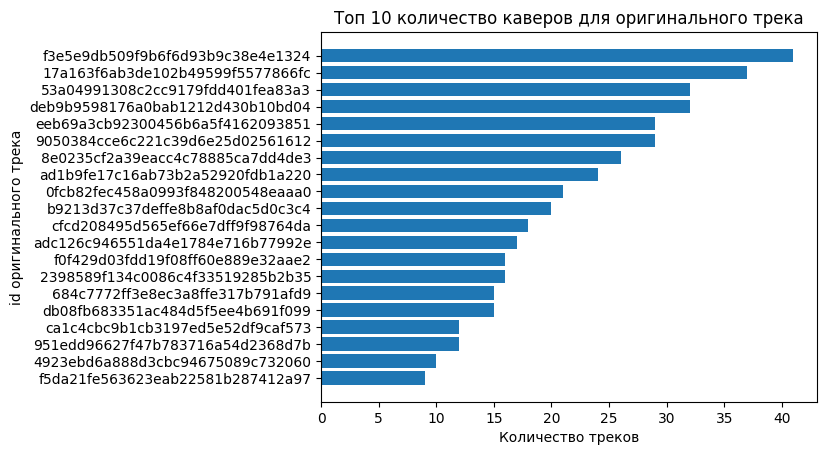

In [21]:
plt.title('Топ 10 количество каверов для оригинального трека')
plt.barh(df_group['original_track_id'], df_group['track_id'])
plt.xlabel('Количество треков')
plt.ylabel('id оригинального трека')
plt.show()

In [22]:
grouped_data = df_union.groupby(['track_remake_type'])['original_track_id'].value_counts()

grouped_data.head()

track_remake_type  original_track_id               
COVER              f3e5e9db509f9b6f6d93b9c38e4e1324    39
                   17a163f6ab3de102b49599f5577866fc    32
                   53a04991308c2cc9179fdd401fea83a3    32
                   deb9b9598176a0bab1212d430b10bd04    31
                   9050384cce6c221c39d6e25d02561612    27
Name: original_track_id, dtype: int64

In [23]:
# cгруппировали данные по количеству названий песен для категории кавер-оригинал
grouped_data1 = df_union.groupby(['track_remake_type'])['title'].value_counts()
grouped_data1 

track_remake_type  title                    
COVER              Morena                       81
                   Rolê                         72
                   Wicked Game                  69
                   Esquema Preferido            66
                   Facas                        57
                                                ..
ORIGINAL           создавай                      1
                   сон                           1
                   там, где хорошо               1
                   финиш                         1
                   я краснею при тебе как...     1
Name: title, Length: 46165, dtype: int64

In [24]:
grouped_data2 = df_union.groupby(['track_remake_type'])['track_id'].value_counts()
grouped_data2 

track_remake_type  track_id                        
COVER              e8fac665a49a756598e82b8170086324    10
                   a315487f8cf61d8bbbf1468546607062     9
                   ecfcc3542d9219bf01cd5fdf92821b79     9
                   17df7b240af924f49e8d8cecb1ec02a5     8
                   8af2e460aed489e82f1099f25a14a51f     8
                                                       ..
ORIGINAL           ffea3e3b0cb0a8b457b1451070f05991     1
                   ffeccd6756798d7263f5191764496fe4     1
                   ffed644410f9ae8c0b4668dfe7c31944     1
                   fff177e8cb2740a02ee8a5fbe77268fb     1
                   ffff9a22aa441db772206280ffb8b52e     1
Name: track_id, Length: 71597, dtype: int64

In [25]:
# cгруппировали данные по количеству песен в определенную дату
grouped_data3 = df_union.groupby(['track_remake_type'])['dttm'].value_counts()
grouped_data3 

track_remake_type  dttm               
COVER              2013-03-11 20:00:00    838
                   2021-08-30 21:00:00    209
                   2012-02-29 20:00:00    186
                   2018-04-14 21:00:00    138
                   2021-12-06 21:00:00    137
                                         ... 
ORIGINAL           2023-09-19 21:00:00      1
                   2023-09-24 21:00:00      1
                   2023-09-26 16:30:13      1
                   2023-10-07 21:00:00      1
                   2023-10-08 21:00:00      1
Name: dttm, Length: 28438, dtype: int64

In [26]:
# cгруппировали данные по количеству названий песен для категории кавер-оригинал
grouped_data3 = df_union.groupby(['dttm'])['track_remake_type'].value_counts()
grouped_data3 

dttm                 track_remake_type
2009-08-10 17:32:06  COVER                1
2009-08-10 20:32:59  COVER                1
2009-08-10 20:44:08  COVER                1
2009-09-14 11:31:37  COVER                1
2009-09-14 11:31:43  COVER                1
                                         ..
2023-10-07 21:00:00  ORIGINAL             1
2023-10-08 21:00:00  COVER                1
                     ORIGINAL             1
2023-10-17 21:00:00  COVER                5
2023-10-18 21:00:00  COVER                1
Name: track_remake_type, Length: 28438, dtype: int64

Мысли вслух

Перед нами стоит задача бинарной классификации. Явного таргета у нас нет, поэтому нам следует сгенерировать новый бинарный признак по столбцу track_remake_type. Следовательно, создадим новый столбец, где '1' - COVER, а '0' - ORIGINAL. После этого удалить столбец 'track_remake_type'.

In [27]:
df_union['target'] = np.where(df_union['track_remake_type']== 'ORIGINAL',0,1)

In [28]:
df_union.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72571 entries, 0 to 72570
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_track_id  5378 non-null   object        
 1   track_id           72571 non-null  object        
 2   track_remake_type  72571 non-null  object        
 3   dttm               72571 non-null  datetime64[ns]
 4   title              72571 non-null  object        
 5   language           22598 non-null  object        
 6   isrc               72242 non-null  object        
 7   genres             72571 non-null  object        
 8   duration           72571 non-null  float64       
 9   lyricId            11097 non-null  object        
 10  text               11097 non-null  object        
 11  target             72571 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(9)
memory usage: 6.9+ MB


In [29]:
# посмотрим пропуски
df_union.isna().sum() 

original_track_id    67193
track_id                 0
track_remake_type        0
dttm                     0
title                    0
language             49973
isrc                   329
genres                   0
duration                 0
lyricId              61474
text                 61474
target                   0
dtype: int64

In [30]:
# проверим дубликаты по customerID
df_union['track_id'].duplicated().sum()

974

In [31]:

df_union['isrc'].duplicated().sum()

1455

In [32]:
# проверим дубликаты по 'original_track_id'
df_union['original_track_id'].duplicated().sum()

68102

In [33]:
# посмотрим период за который у нас есть данные 
max_date = df_union['dttm'].max()
min_date = df_union['dttm'].min()
print(f'Данные представлены за период c {min_date} по {max_date}')

Данные представлены за период c 2009-08-10 17:32:06 по 2023-10-18 21:00:00


**Изучим, что такое ISRC**    
ISRC – уникальный код, который однозначно и навсегда определяет музыкальную или видеозапись.

Именно запись, не песню в целом. Разным версиям одной песни или видео (ремиксы, вырезки и т. д.) должны быть присвоены различные уникальные кодыКод можно присваивать записи как сразу после ее написания, так и «задним числом» – через любой промежуток времени после ее публикации.– ISRC является самым простым и оперативным способом идентификации владельца прав на музыкальное или видео произведение в случае, если после присвоения кода владелец прав не менялся.

– В большинстве случаев, с помощью кода можно определить год и страну написания записи.
.

ISRC RU — B94 — 13 — 00137 (ISRC RUB941300137)
ISRC RU B94 13 00137
Идентификатор кода Код страны (2 буквы)RU = Россия Код регистранта(3 символа)B94 = Концертно-продюсерский центр Год присваивания кода(2 цифры)13 = 2013 Номер записи(5 цифр). 

In [34]:
# Извлекаем год из столбца isrc
df_union['year_of_track'] = df_union['isrc'].str[5:7]
df_union['year_of_track'] 

0        69
1        69
2        69
3        04
4        07
         ..
72566    23
72567    23
72568    23
72569    00
72570    23
Name: year_of_track, Length: 72571, dtype: object

In [35]:
df_union.head()

,original_track_id,track_id,track_remake_type,dttm,title,language,isrc,genres,duration,lyricId,text,target,year_of_track
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,2009-11-11 21:00:00,Proud Mary,EN,USFI86900049,"[ROCK, ALLROCK]",187220.0,260f21d9f48e8de874a6e844159ddf28,Left a good job in the city\nWorkin' for the m...,0,69
1,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,2009-11-11 21:00:00,Proud Mary,EN,USFI86900049,"[ROCK, ALLROCK]",187220.0,f3331cf99637ee24559242d13d8cf259,Left a good job in the city\nWorkin' for the m...,0,69
2,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL,2009-11-11 21:00:00,Fortunate Son,EN,USFI86900065,"[ROCK, ALLROCK]",137780.0,2498827bd11eca5846270487e4960080,Some folks are born made to wave the flag\nOoh...,0,69
3,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL,2009-09-21 20:00:00,La Camisa Negra,ES,USUL10400965,"[POP, FOLK, LATINFOLK]",216840.0,5237001311d4062bf2b80de30652bf58,"Uno por pobre y feo, hombre\nPero antoja'o, ay...",0,04
4,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,2009-11-16 21:00:00,The Way I Are,EN,USUM70722806,"[FOREIGNRAP, RAP]",179660.0,e5b1b57090b728e8d98d2b4d9b781bf4,"Yeah!... yeah!... remember the time, baby... y...",0,07


In [36]:
# Извлекаем страну из столбца isrc
df_union['country_of_track'] = df_union['isrc'].str[2:4]
df_union['country_of_track'] 

0        FI
1        FI
2        FI
3        UL
4        UM
         ..
72566    AG
72567    AH
72568    AH
72569    RU
72570    A0
Name: country_of_track, Length: 72571, dtype: object

In [37]:
# получим информацию о годах появления информации о треке
df_union['dttm'].dt.year.sort_values().unique()

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023], dtype=int64)

In [38]:
df_union['year_of_relize'] = pd.to_datetime(df_union['dttm'], utc=True).dt.year

In [39]:
# cгруппировали данные по количеству названий песен для категории кавер-оригинал
grouped_data3 = df_union.groupby(['lyricId'])['track_id'].value_counts()
grouped_data3 

lyricId                           track_id                        
000be29f570db2ccdab76e0197274e83  004ebdf661399f4edaa3c35aef6741d2    1
0011ebf6e2f4e8c0d9d0cd3616e06414  c3047b0018ecde22f44357ea7b159a1b    1
00218ccd88f32b08b25fbd986f5d35b5  2449a50bbafbdb143d601d613760ca0a    1
0021c4234474a888a4c137031e8fb44e  483c39e52db86cf9c37691383035a32a    1
0023527d56db427ac10faae97d314863  73d281bd290358921949e3b1bac7c4ff    1
                                                                     ..
ffe9d9141304723987a544f613684bc3  510404d4a0c5bf41b3e30eb1bca0bcac    1
ffe9f73b579abae57ea04b52c6c5a64e  f9749b71158c6e65c76af45b8773492c    1
fff249858b2d160946da7b8613aa15da  7a459e7f55ee67ca271bdc7275dd7413    1
fff827dd62e29ed99a1bbd85c07b8f84  3a067314626725cf82f451d9b77619f2    1
fff9fde7068943183f84ab56d6b3b3fb  76296f6a4b91025100b5667d1b404dd4    1
Name: track_id, Length: 11097, dtype: int64

In [40]:
df_union

,original_track_id,track_id,track_remake_type,dttm,title,language,isrc,genres,duration,lyricId,text,target,year_of_track,country_of_track,year_of_relize
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,2009-11-11 21:00:00,Proud Mary,EN,USFI86900049,"[ROCK, ALLROCK]",187220.0,260f21d9f48e8de874a6e844159ddf28,Left a good job in the city\nWorkin' for the m...,0,69,FI,2009
1,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,2009-11-11 21:00:00,Proud Mary,EN,USFI86900049,"[ROCK, ALLROCK]",187220.0,f3331cf99637ee24559242d13d8cf259,Left a good job in the city\nWorkin' for the m...,0,69,FI,2009
2,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL,2009-11-11 21:00:00,Fortunate Son,EN,USFI86900065,"[ROCK, ALLROCK]",137780.0,2498827bd11eca5846270487e4960080,Some folks are born made to wave the flag\nOoh...,0,69,FI,2009
3,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL,2009-09-21 20:00:00,La Camisa Negra,ES,USUL10400965,"[POP, FOLK, LATINFOLK]",216840.0,5237001311d4062bf2b80de30652bf58,"Uno por pobre y feo, hombre\nPero antoja'o, ay...",0,04,UL,2009
4,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,2009-11-16 21:00:00,The Way I Are,EN,USUM70722806,"[FOREIGNRAP, RAP]",179660.0,e5b1b57090b728e8d98d2b4d9b781bf4,"Yeah!... yeah!... remember the time, baby... y...",0,07,UM,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72566,4788e0bf61d80ef5ec9380aa8a8119d9,4788e0bf61d80ef5ec9380aa8a8119d9,ORIGINAL,2023-09-28 21:00:00,"Милый, прощай",None,RUAGT2312928,"[POP, RUSPOP]",178980.0,NaN,NaN,0,23,AG,2023
72567,None,78b2db35476f134dc3cdfbf4d77ba034,COVER,2023-10-01 13:55:45,Habits (Stay Hight),EN,TCAHK2396284,[ELECTRONICS],149570.0,NaN,NaN,1,23,AH,2023
72568,None,e720ff378efe032df56e0e656a6a92d3,COVER,2023-10-05 21:00:00,Arcade,EN,TCAHM2318975,"[FOREIGNBARD, BARD]",201580.0,NaN,NaN,1,23,AH,2023
72569,554e33d79e258da91149c3a4985cf6a1,554e33d79e258da91149c3a4985cf6a1,ORIGINAL,2023-10-05 21:00:00,Май,None,SMRUS0076417,"[RUSRAP, RAP]",156870.0,NaN,NaN,0,00,RU,2023


In [41]:
df_union = df_union.drop(['original_track_id','track_id','dttm','lyricId','track_remake_type','text'], axis= 1)

In [45]:
df_union = df_union.drop(['genres'], axis= 1)

KeyError: "['genres'] not found in axis"

In [46]:
df_union = df_union.fillna('No')

Подготовка признаков для обучения Baseline модели

In [ ]:
import sys
#!{sys.executable} -m pip install spacy

#!{sys.executable} -m spacy download en
import spacy

Создадим новый столбец lemm_text с обработанным текстом, который будет нашим основным признаком для модели.

In [ ]:
# загрузим объект nlp
disabled_pipes = ['parser','ner']
nlp = spacy.load("en_core_web_sm",disable=disabled_pipes)

# напишем функцию
def lemmatize(text):
    text = text.lower()
    text = nlp(text)
    lemm_text = " ".join([token.lemma_ for token in text])
    clear_text = re.sub(r'[^a-zA-Z ]', ' ', lemm_text)
    return  " ".join(clear_text.split())          

In [ ]:
#tqdm.pandas("lemmatize")
df_union['lemm_text'] = df_union['text'].progress_apply(lemmatize) 


In [ ]:
# проверим работу функции на произвольной строке
print("Исходный текст:", df_union['text'][47])
print("Очищенный и лемматизированный текст:", lemmatize(df_union['text'][47]))

## Выбор и обучение моделей

Подготовка призанков для обучения моделей.

In [47]:
# cоздадим переменные для признаков и целевого признака
X = df_union.drop('target', axis=1)
y = df_union['target']

Далее разобьем данные на выборки. Разделим исходные данные на обучающую и тестовую выборки. Данные разобьем на 2 части, в соотношении 75:25. Добавим аргумент stratify, он позволит сохранить изначальное распределение таргетов во всех новых датасетах. Существующий дисбаланс никуда не денется, но в каждом датасете он будет одинаковым.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE,stratify = y
)

In [49]:
# выведем на экран размеры таблиц, которые хранятся в 4-х переменных 
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((54428, 7), (54428,), (18143, 7), (18143,))

### Обучение моделей


Модель CatBoostClassifier

In [50]:
#численные признаки
num_cols = X_train.select_dtypes(exclude='object').columns.to_list()
num_cols

['duration', 'year_of_relize']

In [51]:
# создадим переменную с категориальными признаками для передачи в модель
cat_features = X_train.select_dtypes(include='object').columns.to_list()
cat_features

['title', 'language', 'isrc', 'year_of_track', 'country_of_track']

In [56]:
pipeline_catboost = Pipeline([
    ('cb', CatBoostClassifier(cat_features=cat_features,random_state=RANDOM_STATE))
])

parameters_catboost = {
    'cb__iterations': [100],
    'cb__depth': [3,6,9],
    'cb__learning_rate': [0.01, 0.15]
}

In [57]:
gs_model_cb = GridSearchCV(
    estimator = pipeline_catboost,
    param_grid=parameters_catboost, 
    scoring='roc_auc',
    cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1)

In [58]:
%%time
gs_model_cb.fit(X_train, y_train)

0:	learn: 0.5743181	total: 222ms	remaining: 22s
1:	learn: 0.4870442	total: 280ms	remaining: 13.7s
2:	learn: 0.4192059	total: 350ms	remaining: 11.3s
3:	learn: 0.3654148	total: 442ms	remaining: 10.6s
4:	learn: 0.3219229	total: 553ms	remaining: 10.5s
5:	learn: 0.2866533	total: 735ms	remaining: 11.5s
6:	learn: 0.2579822	total: 802ms	remaining: 10.7s
7:	learn: 0.2338978	total: 863ms	remaining: 9.92s
8:	learn: 0.2134928	total: 921ms	remaining: 9.31s
9:	learn: 0.1972346	total: 1.01s	remaining: 9.06s
10:	learn: 0.1834683	total: 1.1s	remaining: 8.94s
11:	learn: 0.1708116	total: 1.26s	remaining: 9.27s
12:	learn: 0.1609068	total: 1.36s	remaining: 9.1s
13:	learn: 0.1518926	total: 1.5s	remaining: 9.2s
14:	learn: 0.1446305	total: 1.64s	remaining: 9.29s
15:	learn: 0.1380533	total: 1.75s	remaining: 9.21s
16:	learn: 0.1319648	total: 1.83s	remaining: 8.93s
17:	learn: 0.1266159	total: 1.89s	remaining: 8.61s
18:	learn: 0.1226856	total: 1.96s	remaining: 8.36s
19:	learn: 0.1190730	total: 2.17s	remaining: 8.

GridSearchCV(cv=KFold(n_splits=5, random_state=54321, shuffle=True),
             estimator=Pipeline(steps=[('cb',
                                        <catboost.core.CatBoostClassifier object at 0x000002B722DB2FD0>)]),
             n_jobs=-1,
             param_grid={'cb__depth': [3, 6, 9], 'cb__iterations': [100],
                         'cb__learning_rate': [0.01, 0.15]},
             scoring='roc_auc')

In [61]:
# выведем лучшие значения гиперпараметров, полученные на GridSearch


best_model_cb = gs_model_cb.best_estimator_

gs_model_cb_best_score = gs_model_cb.best_score_
gs_model_cb_best_params = gs_model_cb.best_params_

print(f'Best params CatBoostClassifier: {gs_model_cb_best_params}')
print(f'ROC-AUC CatBoostClassifier: {gs_model_cb_best_score}')

Best params CatBoostClassifier: {'cb__depth': 9, 'cb__iterations': 100, 'cb__learning_rate': 0.15}
ROC-AUC CatBoostClassifier: 0.9804098279970589


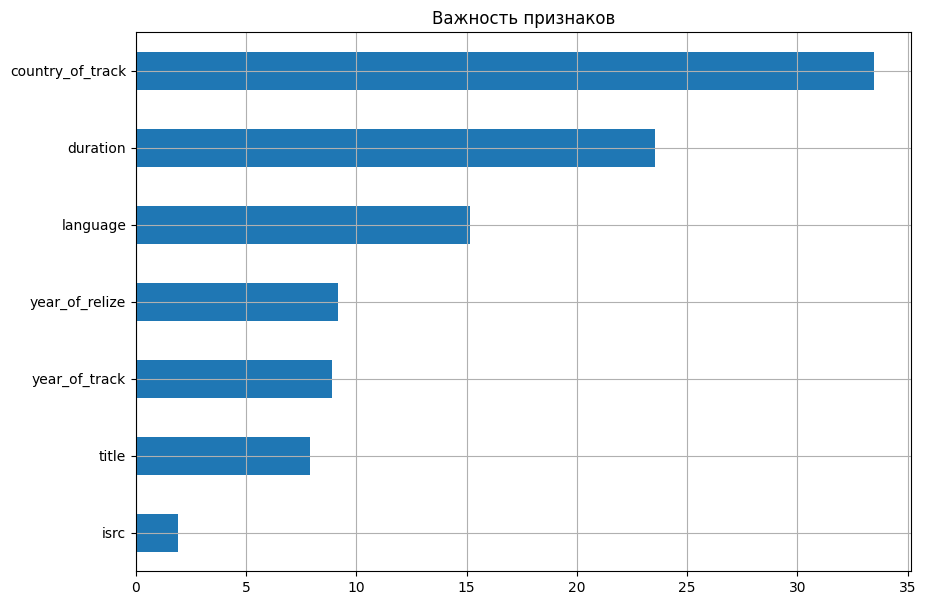

In [63]:
# построим гистограмму значимости признаков для модели CatBoost
# значения отсортированные по возрастанию влияния

plt.figure(figsize = (10,7))
importances = pd.Series(best_model_cb.named_steps['cb'].feature_importances_,index=best_model_cb['cb'].feature_names_).sort_values()

# график
importances.plot.barh(grid=True, title='Важность признаков');

In [65]:
predict_test = best_model_cb.predict(X_test)

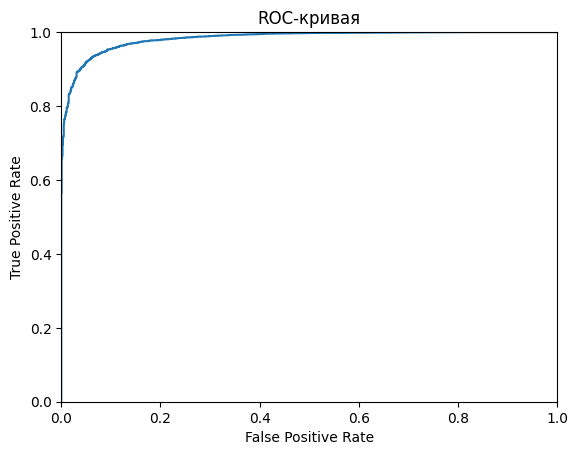

In [69]:
probabilities_test = best_model_cb.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

In [70]:
# рассчитаем дополнительные метрики
print(f'Accuracy: {accuracy_score(y_test, predict_test)}')    
print(f'Полнота: {recall_score(y_test, predict_test)}')     
print(f'Точность: {precision_score(y_test, predict_test)}')  
print(f'F1-мера: {f1_score(y_test,predict_test)}')          
print(f'AUC-ROC:{roc_auc_score(y_test,probabilities_one_test)}')

Accuracy: 0.9698506310973929
Полнота: 0.9887859292923331
Точность: 0.979135008766803
F1-мера: 0.9839368043931519
AUC-ROC:0.9829254461036021


### Обучение моделей

In [ ]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(X_train,y_train)
dummy_model.score(X_train,y_train)